In [1]:
from scipy.optimize import linprog
import numpy as np
import math
from electricity_prices import read_prices
from datetime import datetime, timedelta

import json
import pandas as pd

from hackaton import get_temperature_array, get_energy_array, printResults, saveJsonFIle, get_data_from_multiple_days, get_data_from_month, get_data_from_week, create_json_object

# GLOBAL VARS

In [2]:
CONFORT_PROVIDED_MODE_ECO=4
CONFORT_PROVIDED_MODE_CONFORT=8


#Table values (should be global vars)
MODE_OFF_CONSUMPTION = 1

MODE_ECO_CONSUMPTION_TEMPERATURE_LOWER_10 = 1.6
MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20 = 0.8
MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_20 = 0.4

MODE_CONFORT_CONSUMPTION_TEMPERATURE_LOWER_0 = 2.4+9
MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_0_LOWER_10 = 2.4
MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20 = 1.6
MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_20 = 0.8





# Hackaton

C -> Electricity Cost

72 weights ( represent the cost of each hour per mode)
- w00, w01, w02, w03, w04, w05, w06, w07, ...

modes (hours_mode_off, hours_mode_eco, hours_mode_confort)
- h_00_off, h_00_eco, h_00_conf, h_01_off, h_01_eco, h_01_conf, ...

this modes are binary variables (0 or 1)


Expression
- C = w00*h_00_off + w01*h_00_eco + w02*h_00_conf + w03*h_01_off + w04*h_01_eco + w05*h_01_conf + w06*h_02_off + w07*h_02_eco + w08*h_02_conf + ...


Contraints

Binary Variables and Confort score at least 124
- h_00_off + h_00_eco + h_00_conf = 1
- h_01_off + h_01_eco + h_01_conf = 1
...
 - 124 <= (h_00_eco + h_01_eco + h_02_eco + ... + h_23_eco)*4 +(h_00_conf + h_01_conf + ... + h_23_conf)*8

In [3]:
def OptimizeCost(Weights, costs, consumptionForEachWeight, temperature_array, minumum_confort_score=124):
    """inputs:
    Weights: list of weights for each hour
    contraints: list of contraints
    bounds: list of bounds
    integrality: 1 : Integer variable; decision variable must be an integer within bounds."""
    #Optimize cost
    #weights

    #contraints
    lhs_eq = [[1, 1, 1]+[0]*69, [0]*3+[1]*3+[0]*66, [0]*6+[1]*3+[0]*63, [0]*9+[1]*3+[0]*60, [0]*12+[1]*3+[0]*57, [0]*15+[1]*3+[0]*54, [0]*18+[1]*3+[0]*51, [0]*21+[1]*3+[0]*48, [0]*24+[1]*3+[0]*45, [0]*27+[1]*3+[0]*42, [0]*30+[1]*3+[0]*39, [0]*33+[1]*3+[0]*36, [0]*36+[1]*3+[0]*33, [0]*39+[1]*3+[0]*30, [0]*42+[1]*3+[0]*27, [0]*45+[1]*3+[0]*24, [0]*48+[1]*3+[0]*21, [0]*51+[1]*3+[0]*18, [0]*54+[1]*3+[0]*15, [0]*57+[1]*3+[0]*12, [0]*60+[1]*3+[0]*9, [0]*63+[1]*3+[0]*6, [0]*66+[1]*3+[0]*3, [0]*69+[1]*3]
    rhs_eq = [1]*24

    #lhs_ineq = [[0, -4, -8, 0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8]]
    lhs_ineq = [[0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT, 0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT,0, -CONFORT_PROVIDED_MODE_ECO, -CONFORT_PROVIDED_MODE_CONFORT]]
    
    rhs_ineq = [-minumum_confort_score]

    bounds = [(0,1) for i in range(72)]
    integrality = [1 for i in range(72)]

    opt = linprog(c=Weights, A_ub=lhs_ineq, b_ub=rhs_ineq,
              A_eq=lhs_eq, b_eq=rhs_eq, bounds=bounds, integrality=integrality,
              method="highs")

    cost = np.dot(opt['x'], costs)

    #find if its eco, off or conf and conver to string 
    policy = np.array(opt['x']).reshape(24,3).argmax(axis=1)
    #convert array number to off, eco or confort
    policy = np.vectorize(lambda x: 'off' if x == 0 else 'eco' if x == 1 else 'conf')(policy)
    
    #cost = opt['fun']
    score = np.array(minumum_confort_score)+opt['ineqlin']['residual'][0]
    
    #comfort score accumulated across the day
    accumulated_comfort_score = [CONFORT_PROVIDED_MODE_CONFORT if policy[i] == 'conf' else CONFORT_PROVIDED_MODE_ECO if policy[i] == 'eco' else 0 for i in range(24)]
    for i in range(1,24):
        accumulated_comfort_score[i] = accumulated_comfort_score[i-1]+accumulated_comfort_score[i]
    
    #cost accumulated across the day
    #need to check weights and see which are active

    #Consumo energético atual e acumulado -> weights
    accumulated_cost = []
    accumulated_comsumption = []
    weights_count = 0
    for mode in policy:
        if mode == 'conf':
            accumulated_cost.append(Weights[2+weights_count])
            accumulated_comsumption.append(consumptionForEachWeight[2+weights_count])
        elif mode == 'eco':
            accumulated_cost.append(Weights[1+weights_count])
            accumulated_comsumption.append(consumptionForEachWeight[1+weights_count])
        else:
            accumulated_cost.append(Weights[weights_count])
            accumulated_comsumption.append(consumptionForEachWeight[weights_count])
        weights_count += 3
    atual_cost= accumulated_cost.copy()
    atual_comsumption= accumulated_comsumption.copy()
    for i in range(1,24):
        accumulated_cost[i] = accumulated_cost[i-1]+accumulated_cost[i]
        accumulated_comsumption[i] = accumulated_comsumption[i-1]+accumulated_comsumption[i]

    #Comsumption accumulated across the day
    # receives the consumption for each weight
       

    return policy, cost, accumulated_comfort_score[-1], accumulated_comfort_score, atual_cost, accumulated_cost, atual_comsumption, accumulated_comsumption, temperature_array


In [4]:
#Temperatures set by eco and confort modes
MODE_ECO_TEMPERATURE = 19
MODE_CONFORT_TEMPERATURE = 25
HEAT_DISSIPATION_RATE = 0.1

def expectedTemperature(internal_temperature, external_temperature, mode):

    if mode == 'conf':
        #if the internal temperature is higher than the confort temperature, the heat is dissipated
        if internal_temperature > MODE_CONFORT_TEMPERATURE:
            internal_temperature = MODE_CONFORT_TEMPERATURE
        #if the internal temperature is lower than the confort temperature, the heat is absorbed
        elif internal_temperature < MODE_CONFORT_TEMPERATURE:
            internal_temperature += (external_temperature - internal_temperature) * HEAT_DISSIPATION_RATE+((MODE_CONFORT_TEMPERATURE - internal_temperature)*2/MODE_CONFORT_TEMPERATURE)
    elif mode == 'eco':
        #if the internal temperature is higher than the eco temperature, the heat is dissipated
        if internal_temperature > MODE_ECO_TEMPERATURE:
            internal_temperature = MODE_ECO_TEMPERATURE
        #if the internal temperature is lower than the eco temperature, the heat is absorbed
        elif internal_temperature < MODE_ECO_TEMPERATURE:
            internal_temperature += (external_temperature - internal_temperature) * HEAT_DISSIPATION_RATE+((MODE_ECO_TEMPERATURE - internal_temperature)*2/MODE_ECO_TEMPERATURE)
    else:
        return internal_temperature

def calculateWeights(temperature_array, energy_cost_array, confort_score_coef=0, min_temperature=20):
    #confort_score_coef is bassicaly the amount of money you are willing to pay for 1 point extra confort
    #Temperature array is the temperature for each hour of the day
    #Energy cost array is the cost of energy for each hour of the day

    #need to define how the temperatures change with modes
    

    #calculate the weights for each hour
    weights = []
    comsumption = []
    cost = []
    modes = ['off', 'eco', 'conf']
    for i in range(len(temperature_array)):
        for mode in modes:
            external_temp = temperature_array[i]
            if mode == 'off':
                #1KW/hour regardless of temperature
                weights.append(energy_cost_array[i]*MODE_OFF_CONSUMPTION-(confort_score_coef*0))
                comsumption.append(MODE_OFF_CONSUMPTION)
                cost.append(energy_cost_array[i]*MODE_OFF_CONSUMPTION)
            elif mode == 'eco':
                if external_temp < 10:
                    #1.6KW/hour
                    weights.append(energy_cost_array[i]*MODE_ECO_CONSUMPTION_TEMPERATURE_LOWER_10-(confort_score_coef*4))
                    comsumption.append(MODE_ECO_CONSUMPTION_TEMPERATURE_LOWER_10)
                    cost.append(energy_cost_array[i]*MODE_ECO_CONSUMPTION_TEMPERATURE_LOWER_10)
                elif external_temp >= 10 and external_temp <= 20:
                    #0.8KW/hour
                    weights.append(energy_cost_array[i]*MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20-(confort_score_coef*4))
                    comsumption.append(MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20)
                    cost.append(energy_cost_array[i]*MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20)
                elif external_temp > 20:
                    #0.4KW/hour
                    weights.append(energy_cost_array[i]*MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_20-(confort_score_coef*4))
                    comsumption.append(MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_20)
                    cost.append(energy_cost_array[i]*MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_20)
            elif mode == 'conf':
                if external_temp < 0:
                    #2.4KW/hour+9KW/hour
                    weights.append(energy_cost_array[i]*(MODE_CONFORT_CONSUMPTION_TEMPERATURE_LOWER_0)-(confort_score_coef*8))
                    comsumption.append(MODE_CONFORT_CONSUMPTION_TEMPERATURE_LOWER_0)
                    cost.append(energy_cost_array[i]*(MODE_CONFORT_CONSUMPTION_TEMPERATURE_LOWER_0))
                elif external_temp < 10:
                    #2.4KW/hour
                    weights.append(energy_cost_array[i]*MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_0_LOWER_10-(confort_score_coef*8))
                    comsumption.append(MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_0_LOWER_10)
                    cost.append(energy_cost_array[i]*MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_0_LOWER_10)
                elif external_temp >= 10 and external_temp <= 20:
                    #1.6KW/hour
                    weights.append(energy_cost_array[i]*MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20-(confort_score_coef*8))
                    comsumption.append(MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20)
                    cost.append(energy_cost_array[i]*MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20)
                elif external_temp > 20:
                    #0.8KW/hour
                    weights.append(energy_cost_array[i]*MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_20-(confort_score_coef*8))
                    comsumption.append(MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_20)
                    cost.append(energy_cost_array[i]*MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_20)
    return weights, comsumption, cost
    
        


In [5]:
internal_temperature=15
external_temperature=10
internal_temperature += (external_temperature - internal_temperature) * HEAT_DISSIPATION_RATE+((MODE_ECO_TEMPERATURE - internal_temperature)*2/MODE_ECO_TEMPERATURE)
    
print((external_temperature - internal_temperature) * HEAT_DISSIPATION_RATE )
print(((MODE_CONFORT_TEMPERATURE - internal_temperature)*2/MODE_CONFORT_TEMPERATURE))
print(internal_temperature)

-0.4921052631578947
0.8063157894736842
14.921052631578947


In [6]:
date = '2021-12-01'
temperature_array = get_temperature_array(date)
energy_array = get_energy_array(date)
weights, consumption, cost = calculateWeights(temperature_array, energy_array)
results = OptimizeCost(weights, cost, consumption, temperature_array, minumum_confort_score=124)
print("Policy: ", results[0])
print("Electricity Cost (euros): ", results[1])
print("Confort Score: ", results[2])
print("Accumulated Comfort Score: ", results[3])
print("Atual Cost: ", results[4])
print("Accumulated Cost: ", results[5])
print("Atual Consumption: ", results[6])
print("Accumulated Consumption: ", results[7])
print("Temperature Array: ", results[8])

Policy:  ['conf' 'conf' 'conf' 'conf' 'conf' 'conf' 'eco' 'eco' 'eco' 'eco' 'eco'
 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco'
 'conf']
Electricity Cost (euros):  11.894456
Confort Score:  124
Accumulated Comfort Score:  [8, 16, 24, 32, 40, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 124]
Atual Cost:  [0.61284, 0.6, 0.582624, 0.541608, 0.528288, 0.577104, 0.4355359999999999, 0.46860799999999997, 0.479008, 0.47819200000000006, 0.471008, 0.4534560000000001, 0.43200000000000005, 0.43200000000000005, 0.433632, 0.4355359999999999, 0.45126400000000005, 0.48, 0.49488000000000004, 0.4841600000000001, 0.48096000000000005, 0.47968000000000005, 0.450144, 0.6119279999999999]
Accumulated Cost:  [0.61284, 1.21284, 1.795464, 2.337072, 2.86536, 3.4424639999999997, 3.8779999999999997, 4.346608, 4.825616, 5.303808, 5.774816, 6.2282720000000005, 6.660272000000001, 7.092272000000001, 7.5259040000000015, 7.961440000000001, 8.412704000000002, 8.89

/Users/rmelo/Documents/GitHub/atc-heat-pump/Optimization/electricity_prices.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = read_csv(folder_name + fname, sep=';', skipfooter=1).to_numpy()


In [7]:
date = '2021-12-02'
temperature_array = get_temperature_array(date)
energy_array = get_energy_array(date)
weights, consumption, cost = calculateWeights(temperature_array, energy_array)
results = OptimizeCost(weights, cost, consumption, temperature_array, minumum_confort_score=124)

print("Acumulated Cost: ", results[5])

Acumulated Cost:  [0.4625600000000001, 0.87704, 1.2710400000000002, 1.830168, 2.310888, 2.790888, 3.181288, 3.619256, 4.067416, 4.483416, 4.880216, 5.270456, 5.656216000000001, 6.227176000000001, 6.786136000000001, 7.357096000000001, 7.7428560000000015, 8.140056000000001, 8.568696000000001, 9.016856, 9.465768, 9.872168, 10.257928, 10.720672]


/Users/rmelo/Documents/GitHub/atc-heat-pump/Optimization/electricity_prices.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = read_csv(folder_name + fname, sep=';', skipfooter=1).to_numpy()


([<matplotlib.axis.YTick at 0x7fb85b9298b0>,
 [Text(0, 0, 'conf'), Text(0, 1, 'eco'), Text(0, 2, 'off')])

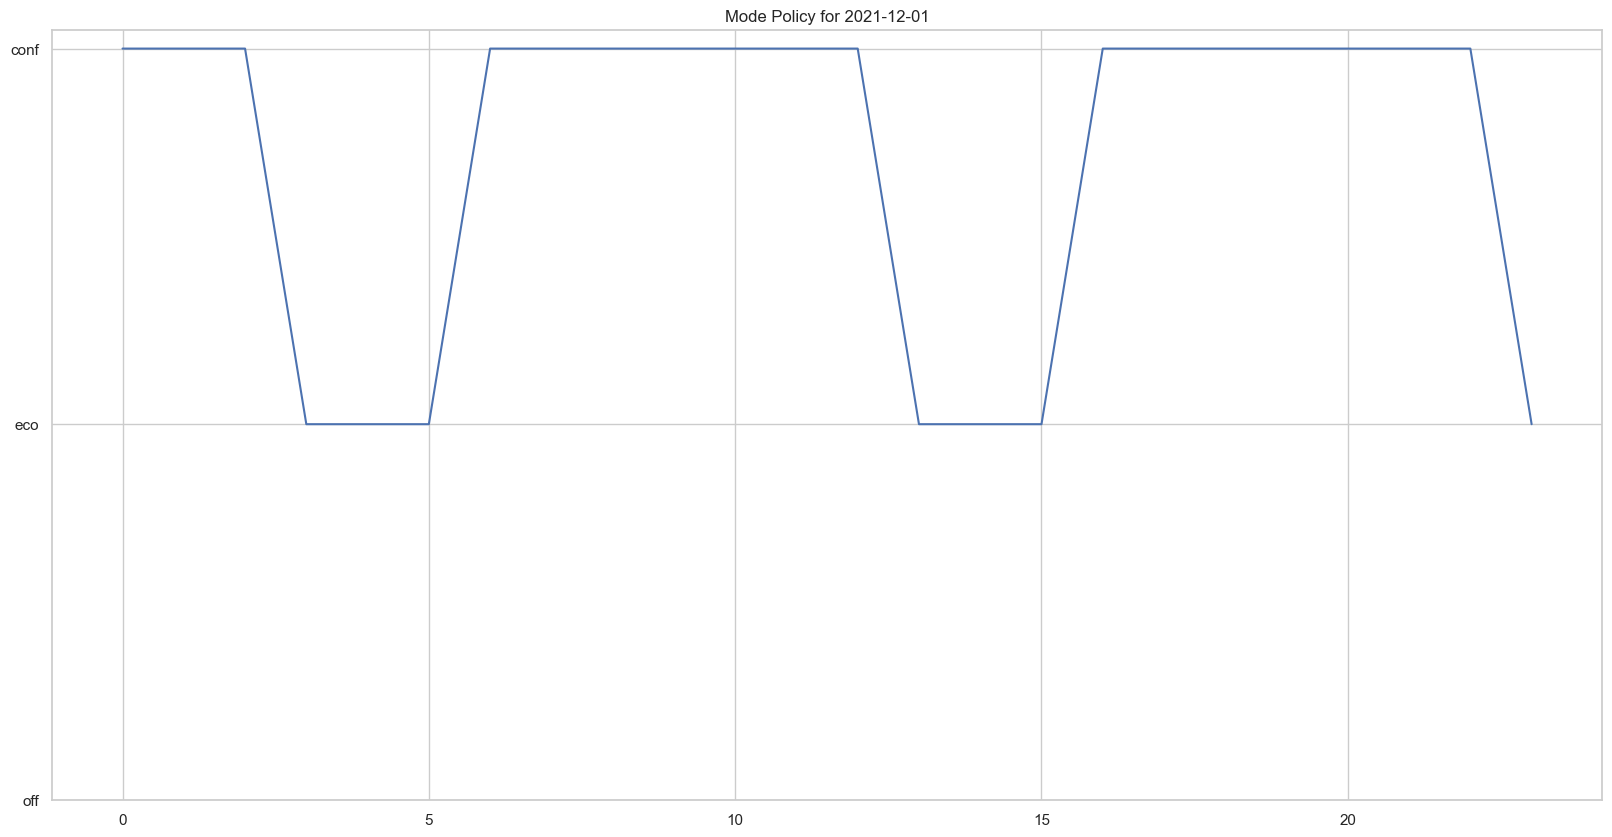

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
#plot the different modes across the day and the energy cost during the day 
plt.figure(figsize=(20,10))

plt.title("Mode Policy for 2021-12-01")
#plot results[0] with y axis order being like ['off', 'eco', 'conf']


plt.plot(results[0])

#change order of y axis to ['off', 'eco', 'conf']
plt.gca().invert_yaxis()
plt.yticks([0,1,2], ['conf', 'eco', 'off'])


#plt.plot(np.vectorize(lambda x: 0 if x == 'off' else 1 if x == 'eco' else 2)(results[0]))

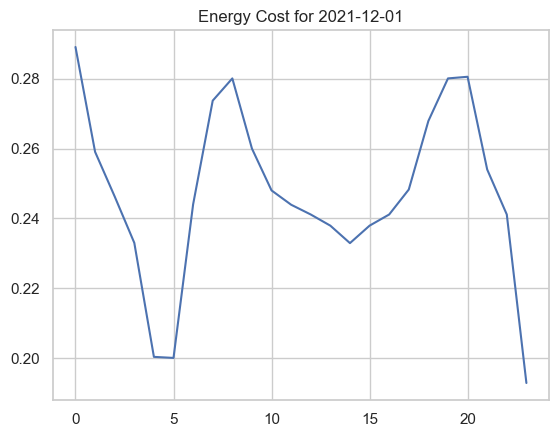

In [9]:
plt.title('Energy Cost for 2021-12-01')
plt.plot(energy_array)


In [ ]:
start_date='2021-12-01'
end_date='2021-12-31'

#get energy cost array
#energy_cost_array = get_energy_array(start_date)
#print(energy_cost_array)

results = get_data_from_multiple_days(start_date, end_date, confort_score_coef=0.00)


#printResults(results)
json_object = create_json_object(results, start_date)

#print json object first entry
print(json_object[0])
#print(json_object[24])
#save json
saveJsonFIle(json_object, "results.json")


# Simulate Policy

In [11]:
def simulate_policy(policy, date):
    #get the temperature array
    temperature_array = get_temperature_array(date)
    #get the energy array

    energy_cost_array = get_energy_array(date)
    #calculate the weights

    #calculate the weights for each hour
    weights = []
    comsumption = []
    cost = []
    modes = ['off', 'eco', 'conf']

    for i in range(len(temperature_array)):
        mode = policy[i]
        external_temp = temperature_array[i]
        if mode == 'off':
            #1KW/hour regardless of temperature
            comsumption.append(MODE_OFF_CONSUMPTION)
            cost.append(energy_cost_array[i]*MODE_OFF_CONSUMPTION)
        elif mode == 'eco':
            if external_temp < 10:
                #1.6KW/hour
                comsumption.append(MODE_ECO_CONSUMPTION_TEMPERATURE_LOWER_10)
                cost.append(energy_cost_array[i]*MODE_ECO_CONSUMPTION_TEMPERATURE_LOWER_10)
            elif external_temp >= 10 and external_temp <= 20:
                #0.8KW/hour
                comsumption.append(MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20)
                cost.append(energy_cost_array[i]*MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20)
            elif external_temp > 20:
                #0.4KW/hour
                comsumption.append(MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_20)
                cost.append(energy_cost_array[i]*MODE_ECO_CONSUMPTION_TEMPERATURE_BIGGER_20)
        elif mode == 'conf':
            if external_temp < 0:
                #2.4KW/hour+9KW/hour
                comsumption.append(MODE_CONFORT_CONSUMPTION_TEMPERATURE_LOWER_0)
                cost.append(energy_cost_array[i]*(MODE_CONFORT_CONSUMPTION_TEMPERATURE_LOWER_0))
            elif external_temp < 10:
                #2.4KW/hour
                comsumption.append(MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_0_LOWER_10)
                cost.append(energy_cost_array[i]*MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_0_LOWER_10)
            elif external_temp >= 10 and external_temp <= 20:
                #1.6KW/hour
                comsumption.append(MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20)
                cost.append(energy_cost_array[i]*MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_10_LOWER_20)
            elif external_temp > 20:
                #0.8KW/hour
                comsumption.append(MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_20)
                cost.append(energy_cost_array[i]*MODE_CONFORT_CONSUMPTION_TEMPERATURE_BIGGER_20)

    
    return consumption, cost

In [12]:
def generateWorkPolicy(work_hours_start, amount_of_work_hours):
    #generate a policy with work hours
    #conf when home, eco when work
    policy = []
    for i in range(24):
        if i < work_hours_start or i >= work_hours_start + amount_of_work_hours:
            policy.append('eco')
        else:
            policy.append('conf')
    return policy

def generateNightPolicy(CurfewHour, SleepHours=8):
    #generate a policy with work hours
    #conf when home, eco when work
    policy = []
    MorningWakingUp = SleepHours+CurfewHour-23
    for i in range(24):
        if i < CurfewHour or i >= MorningWakingUp:
            policy.append('eco')
        else:
            policy.append('conf')
    return policy

In [13]:
Workpolicy = generateWorkPolicy(9, 8)
consumption, cost = simulate_policy(Workpolicy,'2021-12-01')
print("Policy: ", Workpolicy)
print("Electricity Cost (euros): ", sum(cost))
print("Accumulated Consumption: ", sum(consumption))
Nightpolicy = generateNightPolicy(22, SleepHours=8)
consumption, cost = simulate_policy(Nightpolicy,'2021-12-01')
print("Policy: ", Nightpolicy)
print("Electricity Cost (euros): ", sum(cost))
print("Accumulated Consumption: ", sum(consumption))


Policy:  ['eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'conf', 'conf', 'conf', 'conf', 'conf', 'conf', 'conf', 'conf', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco']
Electricity Cost (euros):  12.336535999999997
Accumulated Consumption:  120.0
Policy:  ['eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco', 'eco']
Electricity Cost (euros):  10.542992
Accumulated Consumption:  120.0


/Users/rmelo/Documents/GitHub/atc-heat-pump/Optimization/electricity_prices.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = read_csv(folder_name + fname, sep=';', skipfooter=1).to_numpy()
/Users/rmelo/Documents/GitHub/atc-heat-pump/Optimization/electricity_prices.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = read_csv(folder_name + fname, sep=';', skipfooter=1).to_numpy()
